##### Import & Seed:

In [1]:
# Libraries:
import pysindy as ps
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq, intercept_library_fun, bb_combinations

# Seed:
np.random.seed(999)

### Standard:

In [2]:
# Select ODE & settings:

ode_name = 'SelkovODE' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
alg = 'tv' # help="name of the benchmark", type=str, default='tv', choices=['tv', 'spline', 'gp']
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10


ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T_SR = 15

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=2)

# save data:
file_path = 'saved/data/selkov_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 300, 2) (50, 300, 2) (0,)
['X0', 'X1']


In [3]:
# additional building blocks -> running SR-T:

print('Equation 1:')
print('')
building_blocks_lambda_0, function_names_0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg, seed=seed, n_seed=n_seed, T=T_SR)
print('')
print('Equation 2:')
print('')
building_blocks_lambda_1, function_names_1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg, seed=seed, n_seed=n_seed, T=T_SR)

file_path = 'saved/building_blocks/selkov_bb_0.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda_0, function_names_0), f)
file_path = 'saved/building_blocks/selkov_bb_1.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda_1, function_names_1), f)


Equation 1:

Running with: ode_name=SelkovODE, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (151, 50, 2)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.79          62673.8       12         0.166613         0.158029      1.59m


/Users/grgromano/Documents/polimi/thesis/repos/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     5.45          62.8276       21          0.10559         0.105365      1.18m
   2     4.74          317.767       21         0.104602         0.114256     52.53s
   3     4.35          16.1666        8        0.0726267        0.0752973     32.94s


/Users/grgromano/Documents/polimi/thesis/repos/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   4     5.75          21.4333        8        0.0631675        0.0630584     17.13s
   5     6.36          6.54597        8        0.0628609        0.0658176      0.00s

SR-T model:  C - X0*X1**2

building blocks:
cos(X1 - 0.34636101539428155)
0.6364339667014778
-X0*X1**2
 
number of building blocks:  3
 

Equation 2:

Running with: ode_name=SelkovODE, ode_param=None, x_id=1, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (151, 50, 2)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.79          62673.7       26         0.141245         0.139705      1.45m
   1     5.48          79.7859        8         0.119471         0.117816      1.18m


In [4]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/selkov_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/selkov_bb_0.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)
file_path = 'saved/building_blocks/selkov_bb_1.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)


# combine building blocks:
bbs, fns = bb_combinations(building_blocks_lambda_0, building_blocks_lambda_1, function_names_0, function_names_1, ode.init_high, ode.init_low, dim_x, dim_k)
#print(len(bbs))

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(bbs)):

    # building block library:
    custom_library = ps.CustomLibrary(library_functions=bbs[i], function_names=fns[i])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.09))
    model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 10 and lasso_penalty < 10:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # lasso penalty:
        alpha = 0.01 # regularization parameter
        coefficients = model.coefficients()
        lasso_penalty = np.sum(np.abs(coefficients))

        # final evaluation metric:
        error = mse + alpha * lasso_penalty
        print('')
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


model:
(X0)' = 19.672 1 + -1.877 X0 + 4.906 X1 + -0.908 X0 X1 + -7.733 X1^2 + -20.117 cos(X1 - 0.34636101539428155) + 1.902 X0 cos(X1 - 0.34636101539428155) + 1.911 X1 cos(X1 - 0.34636101539428155) + 0.210 X0 X1 cos(X1 - 0.34636101539428155) + -2.063 X1^2 cos(X1 - 0.34636101539428155)
(X1)' = 1.873 X0 + -1.692 X1 + 0.924 X0 X1 + 0.383 X1^2 + -1.882 X0 cos(X1 - 0.34636101539428155) + 0.615 X1 cos(X1 - 0.34636101539428155) + -0.251 X0 X1 cos(X1 - 0.34636101539428155) + -0.226 X1^2 cos(X1 - 0.34636101539428155)

Too complex model


model:
(X0)' = -47102395268.844 1 + -1177219017.250 X1 + -627764991.089 X0 X1 + -5372529.527 X1^2 + 74009870205.057 0.6364339667014778 + 1849711171.030 X1 0.6364339667014778 + 986378827.779 X0 X1 0.6364339667014778 + 8441612.458 X1^2 0.6364339667014778
(X1)' = -159327451336.419 X1 + -120927889374.764 X0 X1 + 71733145371.280 X1^2 + 250344041441.489 X1 0.6364339667014778 + 190008540874.335 X0 X1 0.6364339667014778 + -112711057428.883 X1^2 0.6364339667014778

Too

In [5]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=bbs[idx], function_names=fns[idx])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.09))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

# library:
print('')
length = 0
#print('library:')
library_terms = final_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)
    length += 1
print('length:', length)
print('')


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart-SINDy model:')
model.print()


1
X0
X1
X0^2
X0 X1
X1^2
-X0*X1**2
X0 -X0*X1**2
X1 -X0*X1**2
X0^2 -X0*X1**2
X0 X1 -X0*X1**2
X1^2 -X0*X1**2
length: 12

Best building block:
['-X0*X1**2']

smart-SINDy model:
(X0)' = 0.749 1 + -0.100 X0 + 0.999 -X0*X1**2
(X1)' = 0.100 X0 + -0.997 X1 + -0.997 -X0*X1**2


Best Model RMSE:  0.004742142216823363


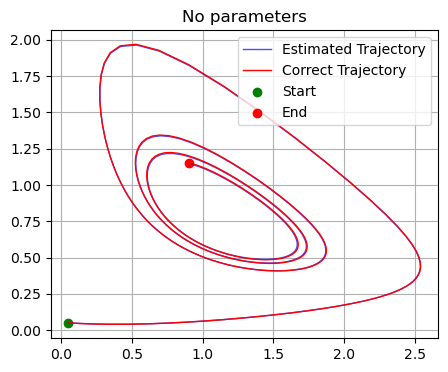

In [6]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'No parameters'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.05, 0.05], [0.05, 0.05], dim_x, dim_k, title=title)

### parameter $\rho$:

In [7]:
# Select ODE & settings:

ode_name = 'SelkovODE_rho' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
alg = 'tv' # help="name of the benchmark", type=str, default='tv', choices=['tv', 'spline', 'gp']
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T_SR = 15

In [3]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=2)

# save data:
file_path = 'saved/data/selkov_data_rho.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 300, 2) (50, 300, 2) (50, 300)
['X0', 'X1', 'X2']


In [8]:
# additional building blocks -> running SR-T:

print('Equation 1:')
print('')
building_blocks_lambda_0, function_names_0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg, seed=seed, n_seed=n_seed, T=T_SR)
print('')
print('Equation 2:')
print('')
building_blocks_lambda_1, function_names_1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg, seed=seed, n_seed=n_seed, T=T_SR)

#save building blocks:
file_path = 'saved/building_blocks/selkov_bb_rho_0.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda_0, function_names_0), f)
file_path = 'saved/building_blocks/selkov_bb_rho_1.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda_1, function_names_1), f)


Equation 1:

Running with: ode_name=SelkovODE_rho, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (151, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.12          28102.6        6         0.228498         0.223527      1.43m
   1     5.51          17.5214        7         0.189557         0.192872      1.19m
   2     4.48          6.92037        6         0.173639         0.176318     51.12s
   3     3.76          3.70498        8         0.078228        0.0804948     32.08s
   4     5.31          5.21624        8        0.0779525        0.0829743     17.16s
   5     6.30          38.4308        8         0.

In [ ]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/selkov_data_rho.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/selkov_bb_rho_0.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)
file_path = 'saved/building_blocks/selkov_bb_rho_1.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)

# combine building blocks:
bbs, fns = bb_combinations(building_blocks_lambda_0, building_blocks_lambda_1, function_names_0, function_names_1, ode.init_high, ode.init_low, dim_x, dim_k)
print(len(bbs))

# manually remove some building blocks, causing compuration issues: 
# bbs.pop(6) 
# bbs.pop(14)
# fns.pop(6)
# fns.pop(14)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(bbs)):

    # building block library:
    custom_library = ps.CustomLibrary(library_functions=bbs[i], function_names=fns[i])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.09))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 10 and lasso_penalty < 10:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # lasso penalty:
        alpha = 0.01 # regularization parameter
        
        # final evaluation metric:
        error = mse + alpha * lasso_penalty
        print('')
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)


11

model:
(X0)' = 0.971 1 + -9.979 X0 + 1.426 X1 + -0.428 X0 X1 + 8.778 X0 X2 + -0.554 X1^2 + -0.584 X1 X2 + -2.223 cos(X1*X2) + 9.839 X0 cos(X1*X2) + -1.245 X1 cos(X1*X2) + 4.360 X2 cos(X1*X2) + 0.418 X0 X1 cos(X1*X2) + -8.730 X0 X2 cos(X1*X2) + 0.240 X1^2 cos(X1*X2) + 0.448 X1 X2 cos(X1*X2) + -2.255 X2^2 cos(X1*X2)
(X1)' = 9.588 X0 + -3.283 X1 + -1.637 X2 + 0.490 X0 X1 + -8.418 X0 X2 + 0.682 X1^2 + 1.602 X1 X2 + 1.137 X2^2 + 0.594 cos(X1*X2) + -9.399 X0 cos(X1*X2) + 1.852 X1 cos(X1*X2) + -0.456 X0 X1 cos(X1*X2) + 8.298 X0 X2 cos(X1*X2) + -0.221 X1^2 cos(X1*X2) + -1.170 X1 X2 cos(X1*X2)

Too complex model


model:
(X0)' = 603206424920.342 X0 + -905843693102.676 X1 + 0.103 X2 + 578277768643.540 X0 X1 + -58705790230.045 X0 X2 + -40770863793.466 X1^2 + 104266077727.016 X1 X2 + -21978329873.137 X2^2 + -904320331949.718 X0 0.6670273835592806 + 1358030742711.015 X1 0.6670273835592806 + -866947569017.676 X0 X1 0.6670273835592806 + 88011064728.005 X0 X2 0.6670273835592806 + 61123223420.305 X

In [10]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=bbs[idx], function_names=fns[idx])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])


# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.09))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart_SINDy model:')
model.print()

Best building block:
['-X0*X1**2']

smart_SINDy model:
(X0)' = 0.029 1 + -0.100 X0 + 0.960 X2 + 0.999 -X0*X1**2
(X1)' = 0.100 X0 + -0.997 X1 + -0.997 -X0*X1**2


Best Model RMSE:  0.007043696738536227


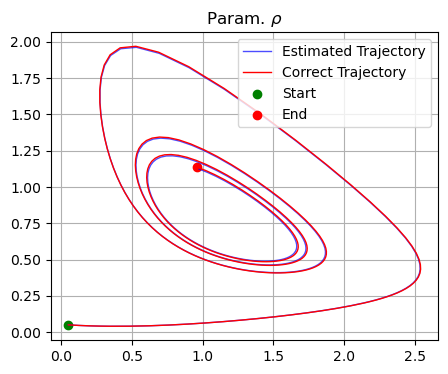

In [11]:
# evaluation:
n_sample = 25
rmse_rho, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low)
print('Best Model RMSE: ', rmse_rho)

n_sample = 1
title = r'Param. $\rho$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.05, 0.05, 0.75], [0.05, 0.05, 0.75], dim_x, title=title)

##### robustness test:

$\rho \simeq 0.9$, RMSE:  0.019263876607910953
$\rho \simeq 0.6$, RMSE:  0.042716159430050984
$\rho \simeq 0.4$, RMSE:  0.05691862123874893


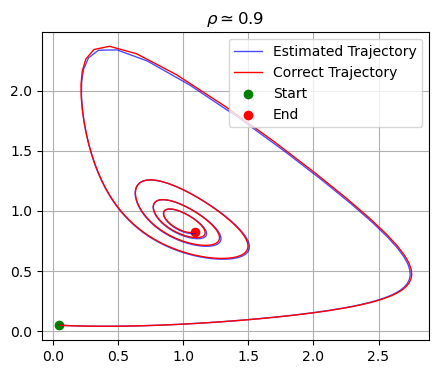

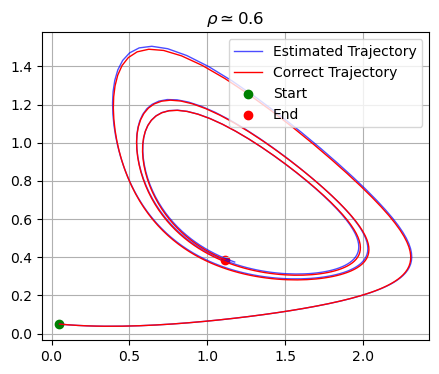

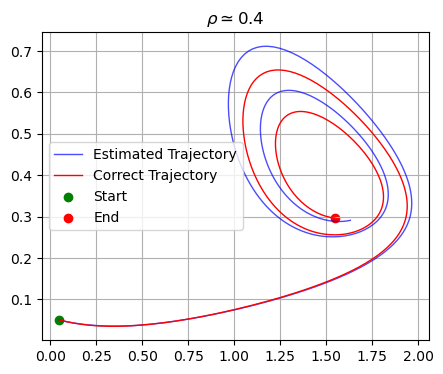

In [12]:
# Best Model, test on different parameter values:

# rho = 0.9
n_sample = 25
rmse_0, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.1, 0.1, 0.95], [0, 0, 0.85])
print(r'$\rho \simeq 0.9$, RMSE: ', rmse_0)
n_sample = 1
init_point = [0.05, 0.05, 0.9]
title = r'$\rho \simeq 0.9$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, init_point, init_point, dim_x, title=title)

# rho = 0.6
n_sample = 25
rmse_0, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.1, 0.1, 0.65], [0, 0, 0.55])
print(r'$\rho \simeq 0.6$, RMSE: ', rmse_0)
n_sample = 1
init_point = [0.05, 0.05, 0.6]
title = r'$\rho \simeq 0.6$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, init_point, init_point, dim_x, title=title)

# rho = 0.4
n_sample = 25
rmse_0, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, [0.1, 0.1, 0.45], [0, 0, 0.35])
print(r'$\rho \simeq 0.4$, RMSE: ', rmse_0)
n_sample = 1
init_point = [0.05, 0.05, 0.4]
title = r'$\rho \simeq 0.4$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, init_point, init_point, dim_x, title=title)

### parameter $\sigma$:

In [13]:
# Select ODE & settings:

ode_name = 'SelkovODE_sigma' # help="name of the ode", type=str
ode_param = None # help="parameters of the ode (default: None)", type=str, default=None
x_id = 0 # help="ID of the equation to be learned", type=int, default=0
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_sigma = 0.01 # help="noise level (default 0)", type=float, default=0.
alg = 'tv' # help="name of the benchmark", type=str, default='tv', choices=['tv', 'spline', 'gp']
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T_SR = 15

In [11]:
# generate data:
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_sigma, dim_x, dim_k)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# ensure existance conditions:
X_list = SINDy_data.existence_conditions(X_list, ode.init_low, n_variables=2)

# save data:
file_path = 'saved/data/selkov_data_sigma.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 300, 2) (50, 300, 2) (50, 300)
['X0', 'X1', 'X2']


In [14]:
# additional building blocks -> running SR-T:

print('Equation 1:')
print('')
building_blocks_lambda_0, function_names_0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_sigma, alg, seed=seed, n_seed=n_seed, T=T_SR)
print('')
print('Equation 2:')
print('')
building_blocks_lambda_1, function_names_1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_sigma, alg, seed=seed, n_seed=n_seed, T=T_SR)

#save building blocks:
file_path = 'saved/building_blocks/selkov_bb_sigma_0.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda_0, function_names_0), f)
file_path = 'saved/building_blocks/selkov_bb_sigma_1.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((building_blocks_lambda_1, function_names_1), f)

Equation 1:

Running with: ode_name=SelkovODE_sigma, ode_param=None, x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (151, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.12          32586.7        6         0.243252         0.235975      1.92m


/Users/grgromano/Documents/polimi/thesis/repos/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/Users/grgromano/Documents/polimi/thesis/repos/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.15          13.3079       14         0.234038         0.227651      1.45m
   2     4.00          12.7774       10         0.199591         0.194794      1.05m
   3     4.02          4.16253       10        0.0741805         0.072347     37.43s
   4     4.72          4.21916       10        0.0738527        0.0752971     18.39s
   5     6.18          38.8789        9        0.0642929        0.0635704      0.00s

SR-T model:  C - X0*X1**2 - X2

building blocks:
X2**0.16469815417251044
cos(X1 - 0.5768728740085401)
cos(X1 - 0.699982888506386)
cos(X1 - 0.7384681902262121)
0.7198269696183968
-X2
-X0*X1**2
 
number of building blocks:  7
 

Equation 2:

Running with: ode_name=SelkovODE_sigma, ode_param=None, x_id=1, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (151, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'log': 1, 'add': 1, 'sub': 1, 'div': 1, 'pow': 1, 'sin': 1, 'cos': 1}
 
    |   Population Average    |             Best Individual      

In [ ]:
# fit and evaluate models:

# upload data:
file_path = 'saved/data/selkov_data_sigma.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

# upload building blocks:
file_path = 'saved/building_blocks/selkov_bb_sigma_0.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)
file_path = 'saved/building_blocks/selkov_bb_sigma_1.pkl'
with open(file_path, 'rb') as f:
    building_blocks_lambda, function_names = dill.load(f)


# combine building blocks:
bbs, fns = bb_combinations(building_blocks_lambda_0, building_blocks_lambda_1, function_names_0, function_names_1, ode.init_high, ode.init_low, dim_x, dim_k)
print(len(bbs))

# manually remove some building blocks, causing compuration issues: 
# bbs.pop(2) 
# fns.pop(2)

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

errors = []
n_features_vec = []
for i in range(len(bbs)):

    # building block library:
    custom_library = ps.CustomLibrary(library_functions=bbs[i], function_names=fns[i])

    # enlarged library, adding the building block to polynomial library:
    generalized_library = ps.GeneralizedLibrary(
        libraries=[polynomial_library, custom_library],
        tensor_array=[[1, 1]] 
    )

    # add the intercept:
    final_library = ps.ConcatLibrary([intercept_library, generalized_library])

    # fitting the model:
    model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.3))
    model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

    # library:
    # print('')
    # print('library:')
    # library_terms = final_library.get_feature_names(input_features=feature_names)
    # for term in library_terms:
    #     print(term)

    # final model:
    print('')
    print('model:')
    model.print()

    # evaluate the model:
    
    # filter too complex models (for sure not correct and likely to crash the code):
    coefficients = model.coefficients()
    lasso_penalty = np.sum(np.abs(coefficients))
    if np.count_nonzero(np.array(model.coefficients())) < 10 and lasso_penalty < 10:

        # compute MSE:
        _, mse = SINDy_data.evaluate_RMSE(model, ode, freq, 10, ode.init_high, ode.init_low, dim_k)

        # lasso penalty:
        alpha = 0.01 # regularization parameter

        # final evaluation metric:
        error = mse + alpha * lasso_penalty
        print('')
        print('error:', error)
    else:
        error = 1000
        print('')
        print('Too complex model')
    
    errors.append(error)
    n_features_vec.append(np.count_nonzero(np.array(model.coefficients())))
    print('')
    

print('errors:', errors)

31

model:
(X0)' = 1.048 X1 + -2.454 X0 X1 + 34.315 X0 X2 + 0.777 X1^2 + 1.106 X1 X2 + 0.634 X2**0.16469815417251044 + 1.436 X0 X1 X2**0.16469815417251044 + -45.466 X0 X2 X2**0.16469815417251044 + -2.209 X1^2 X2**0.16469815417251044
(X1)' = -0.557 1 + 2.078 X0 X1 + -28.021 X0 X2 + -1.208 X1^2 + 1.327 X2**0.16469815417251044 + -3.221 X1 X2**0.16469815417251044 + -0.869 X0 X1 X2**0.16469815417251044 + 36.121 X0 X2 X2**0.16469815417251044 + 2.858 X1^2 X2**0.16469815417251044

Too complex model


model:
(X0)' = 1.706 1 + -1.858 X0 + 0.582 X1 + -1.174 X0 X1 + -0.487 X1^2 + -0.587 X1 X2 + -1.137 cos(X1 - 0.5768728740085401) + 2.199 X0 cos(X1 - 0.5768728740085401) + -0.917 X0 X2 cos(X1 - 0.5768728740085401) + 0.572 X1 X2 cos(X1 - 0.5768728740085401)
(X1)' = -0.986 1 + 1.861 X0 + -1.602 X1 + 1.174 X0 X1 + 0.501 X1^2 + 0.647 X1 X2 + 1.176 cos(X1 - 0.5768728740085401) + -2.203 X0 cos(X1 - 0.5768728740085401) + 0.912 X0 X2 cos(X1 - 0.5768728740085401) + -0.622 X1 X2 cos(X1 - 0.5768728740085401)



In [16]:
# Final model:

min_error = min(errors)
idxs = [i for i, e in enumerate(errors) if abs(e - min_error) < 0.01]
n_features_vec_2 = [n_features_vec[i] for i in idxs]

if len(idxs) > 1:
    print('Multiple models with similar error, choosing the simplest one')
    print('')
    idx = idxs[np.argmin(n_features_vec_2)]
else:
    idx = idxs[0]


# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# custom library with building blocks:
custom_library = ps.CustomLibrary(library_functions=bbs[idx], function_names=fns[idx])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
building_block = custom_library.get_feature_names(input_features=feature_names)

# enlarged library, adding building blocks to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])


# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.3))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)


# best builging block:
print('Best building block:')
print(building_block)
print('')

# final model:
print('smart_SINDy model:')
model.print()

Multiple models with similar error, choosing the simplest one

Best building block:
['-X0*X1**2']

smart_SINDy model:
(X0)' = 0.742 1 + -0.978 X0 X2 + 0.991 -X0*X1**2
(X1)' = -0.984 X1 + 1.001 X0 X2 + -0.983 -X0*X1**2


Best Model RMSE:  0.037311251617660544


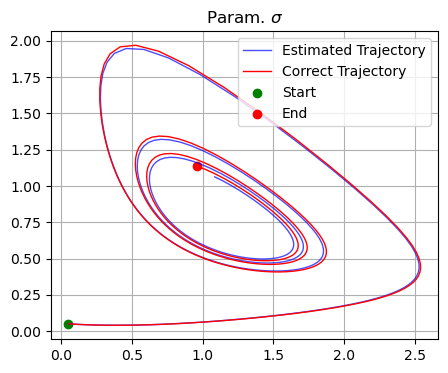

In [17]:
# evaluation
n_sample = 25
rmse_sigma, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_sample, ode.init_high, ode.init_low)
print('Best Model RMSE: ', rmse_sigma)

n_sample = 1
title = r'Param. $\sigma$'
SINDy_data.evaluate_traj(model, ode, freq, n_sample, [0.05, 0.05, 0.1], [0.05, 0.05, 0.1], dim_x, title=title)

### Dev:

In [ ]:
# intercept library + model:

# X0, X1 = sp.symbols('X0 X1')
# intercept = sp.Integer(1)
# intercept_lambda = sp.lambdify((X0, X1), intercept, modules='numpy')
# function_name_intercept = lambda X0, X1: str(intercept)
intercept_library = intercept_library_fun(dim_x+dim_k)

model = ps.SINDy(feature_names=feature_names, feature_library=intercept_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
library_terms = intercept_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

1


In [ ]:
# polynomial library + model:

polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)
polynomial_model = ps.SINDy(feature_names=feature_names, feature_library=polynomial_library, optimizer=ps.STLSQ(threshold=0.1))
polynomial_model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
#polynomial_model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)

library_terms = polynomial_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

# rmse = SINDy_data.evaluate_RMSE(polynomial_model, ode, freq, n_sample, ode.init_high, ode.init_low, dim_k)
# print('RMSE:', rmse)

X0
X1
X2
X0^2
X0 X1
X0 X2
X1^2
X1 X2
X2^2


In [ ]:
# building block library + model:

custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[0]], function_names=[function_names[0]])
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, u=param_list, x_dot=dX_list)
library_terms = custom_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

X0*X1


In [ ]:
# concatenate libraries:

combined_library = ps.ConcatLibrary([constant_library, polynomial_library])
model = ps.SINDy(feature_names=feature_names, feature_library=combined_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
library_terms = combined_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# generalized library:

generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)
model = ps.SINDy(feature_names=feature_names, feature_library=generalized_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

library_terms = generalized_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# build final library from scratch:

X0, X1 = sp.symbols('X0 X1')
intercept = sp.Integer(1)
intercept_lambda = sp.lambdify((X0, X1), intercept, modules='numpy')
function_name_intercept = lambda X0, X1: str(intercept)

constant_library = ps.CustomLibrary(library_functions=[intercept_lambda], function_names=[function_name_intercept])
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)
custom_library = ps.CustomLibrary(library_functions=[building_blocks_lambda[0]], function_names=[function_names[0]])
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)
final_library = ps.ConcatLibrary([constant_library, generalized_library])

model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.1))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
library_terms = final_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [ ]:
# remove repeated building blocks:
N = 10
tol = 1e-3

# random samples:
if ode.dim_x == 1:
    x_samples = np.random.uniform(ode.init_low, ode.init_high, N).reshape(-1, 1) 
else:
    x_samples = np.empty((ode.dim_x, N))
    for i in range(ode.dim_x):
        x_samples[i, :] = np.random.uniform(ode.init_low[i], ode.init_high[i], N) 
x_samples = np.array(x_samples)
#print(x_samples)
#print(np.shape(x_samples))

# evaluate building blocks from eq. 1 at random samples:
f_samples = []
for i in range(len(building_blocks_lambda_0)):
    f_hat = building_blocks_lambda_0[i]
    aux = [f_hat(x_samples[0, i], x_samples[1, i]) for i in range(x_samples.shape[1])]
    f_samples.append(aux)
print(np.shape(f_samples))

In [ ]:
building_blocks_lambda_1_fil = []
function_names_1_fil = []
for i in range(len(building_blocks_lambda_1)):

    flag = 1
    f_hat = building_blocks_lambda_1[i] 
    aux = [f_hat(x_samples[0, i], x_samples[1, i]) for i in range(x_samples.shape[1])]
    for j in range(len(f_samples)):
        if root_mean_squared_error(aux, f_samples[j]) < tol: # filter similar subprograms
            flag = 0
    if flag:
        f_samples.append(aux)
        building_blocks_lambda_1_fil.append(building_blocks_lambda_1[i])
        function_names_1_fil.append(function_names_1[i])

In [ ]:
bbs = [building_blocks_lambda_0[0], building_blocks_lambda_1_fil[0]]
fns = [function_names_0[0], function_names_1_fil[0]]

custom_library = ps.CustomLibrary(library_functions=bbs, function_names=fns)
model = ps.SINDy(feature_names=feature_names, feature_library=custom_library, optimizer=ps.STLSQ(threshold=0.01))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)
library_terms = custom_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)

In [31]:
bbs = [building_blocks_lambda_0[0], building_blocks_lambda_1_fil[0]]
fns = [function_names_0[0], function_names_1_fil[0]]

# intercept library:
intercept_library = intercept_library_fun(dim_x+dim_k)
# polynomial library:
polynomial_library = ps.PolynomialLibrary(degree=2, include_bias=False)

# building block library:
custom_library = ps.CustomLibrary(library_functions=bbs, function_names=fns)

# enlarged library, adding the building block to polynomial library:
generalized_library = ps.GeneralizedLibrary(
    libraries=[polynomial_library, custom_library],
    tensor_array=[[1, 1]] 
)

# add the intercept:
final_library = ps.ConcatLibrary([intercept_library, generalized_library])

# fitting the model:
model = ps.SINDy(feature_names=feature_names, feature_library=final_library, optimizer=ps.STLSQ(threshold=0.09))
model.fit(X_list, t=dt, multiple_trajectories=True, x_dot=dX_list)

# library:
library_terms = final_library.get_feature_names(input_features=feature_names)
for term in library_terms:
    print(term)


1
X0
X1
X0^2
X0 X1
X1^2
X0*X1
-X1*sin(X1**0.6161058799323658)
X0 X0*X1
X0 -X1*sin(X1**0.6161058799323658)
X1 X0*X1
X1 -X1*sin(X1**0.6161058799323658)
X0^2 X0*X1
X0^2 -X1*sin(X1**0.6161058799323658)
X0 X1 X0*X1
X0 X1 -X1*sin(X1**0.6161058799323658)
X1^2 X0*X1
X1^2 -X1*sin(X1**0.6161058799323658)


In [32]:
combined_bb = [
    [lambda_0, lambda_1] 
    for lambda_0 in building_blocks_lambda_0 
    for lambda_1 in building_blocks_lambda_1_fil
]
combined_fn = [
    [fn_0, fn_1] 
    for fn_0 in function_names_0 
    for fn_1 in function_names_1_fil
]
bb_0 = [
    [lambda_0] 
    for lambda_0 in building_blocks_lambda_0 
]
fn_0 = [
    [fn_0] 
    for fn_0 in function_names_0 
]
bb_1 = [
    [lambda_1] 
    for lambda_1 in building_blocks_lambda_1_fil
]
fn_1 = [
    [fn_1] 
    for fn_1 in function_names_1_fil
]

bbs = bb_0 + bb_1 + combined_bb
fns = fn_0 + fn_1 + combined_fn

for i in range(len(bbs)):
    #print(fns[i])
    print(bbs[i])

[<function _lambdifygenerated at 0x10645d760>]
[<function _lambdifygenerated at 0x12f051080>]
[<function _lambdifygenerated at 0x12f051120>]
[<function _lambdifygenerated at 0x12f0511c0>]
[<function _lambdifygenerated at 0x12f051260>]
[<function _lambdifygenerated at 0x12f050f40>]
[<function _lambdifygenerated at 0x10645d760>, <function _lambdifygenerated at 0x12f050f40>]
[<function _lambdifygenerated at 0x12f051080>, <function _lambdifygenerated at 0x12f050f40>]
[<function _lambdifygenerated at 0x12f051120>, <function _lambdifygenerated at 0x12f050f40>]
[<function _lambdifygenerated at 0x12f0511c0>, <function _lambdifygenerated at 0x12f050f40>]
[<function _lambdifygenerated at 0x12f051260>, <function _lambdifygenerated at 0x12f050f40>]
